In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.lines import Line2D

import pandas as pd
import linmix
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr


In [2]:
data = pd.read_csv('data/HRvsAge_Median+STD+Bounds.csv')

# prepare an array for uneven errorbars
xerr = np.array([data['Age_median'].values - data['Age_lower'].values ,data['Age_upper'].values - data['Age_median'].values])

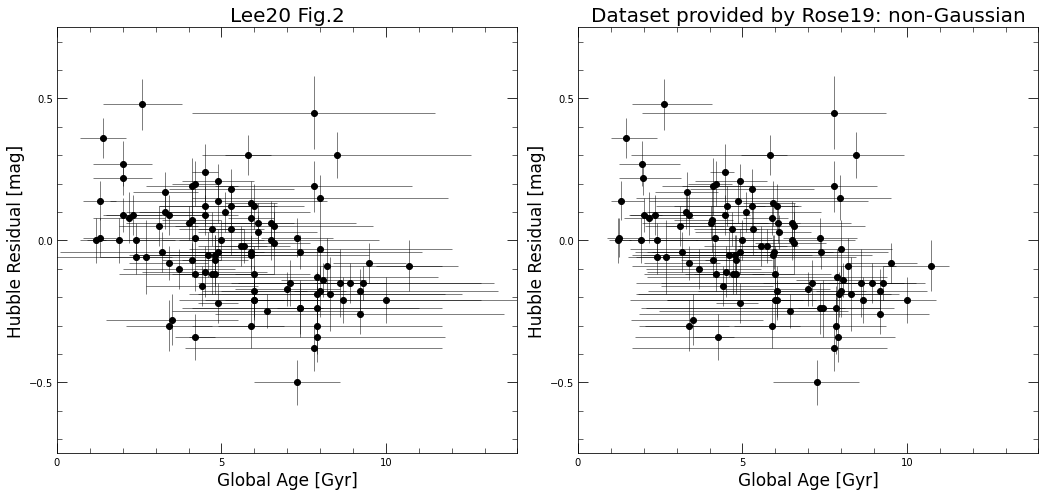

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.errorbar(data['Age_global'],data['HR'],yerr=data['HR_err'],xerr=data['Age_global_err'],fmt='ko',lw=0.5)
ax2.errorbar(data['Age_median'],data['HR'],yerr=data['HR_err'],xerr=xerr,fmt='ko',lw=0.5)

ax1.set_title('Lee20 Fig.2',fontsize=20)
ax2.set_title('Dataset provided by Rose19: non-Gaussian',fontsize=20)
for ax in [ax1,ax2]:
    ax.set_xlabel('Global Age [Gyr]',fontsize=17)
    ax.set_ylabel('Hubble Residual [mag]',fontsize=17)
    ax.set_xlim(0,14)
    ax.set_ylim(-0.75,0.75)
    ax.tick_params(which='major', length=10, direction='in',right=True,top=True)
    ax.tick_params(which='minor', length=5, direction='in',right=True,top=True)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.tight_layout()

## (1-2) MCMC posterior

In [4]:
dataset = 'campbell'   # 'gupta' or 'campbell' or 'campbellG'
filename = 'data/HRvsAge_samples_campbell10k.csv'

In [5]:
samples = pd.read_csv(filename)
samples.head(3)

,SNID,Age0,Age1,Age2,Age3,Age4,Age5,Age6,Age7,Age8,...,HR9990,HR9991,HR9992,HR9993,HR9994,HR9995,HR9996,HR9997,HR9998,HR9999
0,762,4.758532,1.558216,7.348196,4.922079,1.916873,8.067425,8.161599,3.595067,1.897597,...,0.125418,0.111031,0.049721,0.110228,0.061907,0.042606,0.070339,0.103706,0.087285,0.080275
1,1032,7.493606,10.350519,6.692530,5.663809,8.046976,3.958073,2.291889,3.648609,6.861651,...,-0.025980,-0.018704,0.003307,0.020747,-0.027311,-0.010247,-0.025592,0.028176,0.019976,-0.030866
2,1371,1.844475,9.785429,0.805218,10.507561,9.964770,9.645604,10.331896,2.330517,1.195014,...,-0.178016,-0.191690,-0.131175,-0.215081,-0.206989,-0.186684,-0.159390,-0.179546,-0.180692,-0.214565


In [6]:
num_samples = 10000 # 10k samples
length = 103
age_columns = ['Age{}'.format(i) for i in range(num_samples)]
HR_columns  = ['HR{}'.format(i) for i in range(num_samples)]

# put them together
Age_all = samples[age_columns].values.flatten()
HR_all = samples[HR_columns].values.flatten()

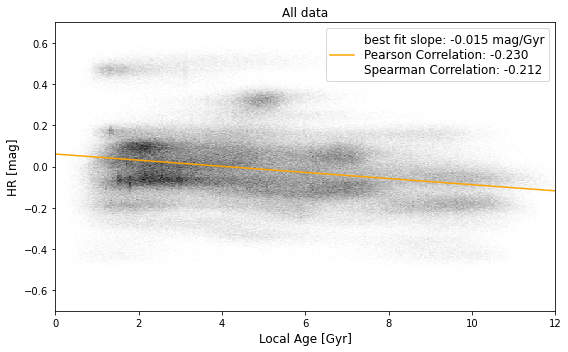

In [7]:
Nbins = 300
cmap = 'gray_r'
x_th = np.linspace(0,14,10)

fig,(ax1) = plt.subplots(1,1,figsize=(8,5))

# Calculate correlations and slope for all
corr = stats.pearsonr(Age_all, HR_all)[0]
rank_corr = stats.spearmanr(Age_all, HR_all)[0]
popt,_ = curve_fit(lambda x,a,b: a*x+b, Age_all, HR_all)
y_th = x_th * popt[0] + popt[1]

ax1.plot(x_th,y_th,c='orange', label=f"best fit slope: {popt[0]:.3f} mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rank_corr:.3f}")
ax1.hist2d(Age_all, HR_all,bins=Nbins,cmap=cmap)
ax1.set_title('All data')


for ax in [ax1]:
    ax.legend(fontsize=12)
    ax.set_xlabel('Local Age [Gyr]',fontsize=12)
    ax.set_ylabel('HR [mag]',fontsize=12)
    ax.set_xlim(0,12)
    ax.set_ylim(-0.7,0.7)
plt.tight_layout()

# (2) LINMIX

In [ ]:
lm1 = linmix.LinMix(data['Age_global'],data['HR'],data['Age_global_err'],data['HR_err'], 
                    K=2,
                    seed=2
                   )
lm1.run_mcmc(silent=True)

lm2 = linmix.LinMix(Age_all[::10], HR_all[::10], 
                    K=2,
                    seed=2
                   )
lm2.run_mcmc(silent=True)

In [ ]:
lm1_slope = lm1.chain['alpha']
plt.hist(lm1_slope)
plt.title(f"LINMIX on Age and HR summary data\nMean: {lm1_slope.mean()} SD: {lm1_slope.std()}")

lm2_slope = lm1.chain['alpha']
plt.hist(lm2_slope)
plt.title(f"LINMIX on Age and HR sampled posterior\nMean: {lm2_slope.mean()} SD: {lm2_slope.std()}")